In [14]:
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import pandas as pd
import urllib2
import re
from sklearn.linear_model import LinearRegression, Ridge
%matplotlib inline

# Web Scraping the CIA World Factbook

<img src="files/CIA-FACTBOOK.png">

# The CIA World Factbook

The CIA World Factbook provides country specific information for each country around the world. The factbook not only includes every country, but also political entity that are either colonies of a coutry or not official countries and Oceans such as: The West Bank, Gibraltar, The Arctic Ocean, and The British Indian Ocean Territory.

Each entry of the factbook includes country-specific information such as population, age distribution, languages, demographics, physical characteristics, and other pieces of information about the country.

Each entry of the factbook does not have the exact same information listed as any other country. For example, the Arctic Ocean and Antartica do not have a GDP or population, so it doesn't make sense to list this in their respective pages.

The World Factbook is funded by the Central Intelligence Agency of the United States and was first compiled in 1981.

# Project Description

In this project, I will scrape the world factbook page of each country and get their the gross domestic product (GDP), population, age distribution (split up into 5 different groups and in terms of %), if the country is landlocked (in terms of '0' or '1'), and the literacry rate of each country.

After scraping each page, I will input this information into an linear regression model from sci-kit learn and find the correlation coefficients of GDP in relation to the other characteristics I scraped from the factbook.

There are no free-standing csv tables in any of the entries. The information is organized in text paragraphs. To see an example of a page click the link below to explore Saudi Arabia's entry on the world factbook. Saudi Arabia's page: https://www.cia.gov/library/publications/the-world-factbook/geos/sa.html

In this project we are first going to scrape the information from the factbook and organize into a pandas data frame, and then analyze it using sci-kit learn's linear regression model.

# Variables

Dependent Variable:

Gross Domestic Product (GDP) - The dependent variable in our regression. It's a measure of the economic output of a country.

Independent Variables:

Population - The number of people living in a country.

0 -14 age distribution - The percentage of the population in this age bracket.

15 - 24  age distribution - The percentage of the population in this age bracket.

25 - 54  age distribution - The percentage of the population in this age bracket.

55 - 64  age distribution - The percentage of the population in this age bracket.

65 to older age distribution - The percentage of the population in this age bracket.

Land Locked - Whether the country is land locked or not. A land locked country has no coastline.

Literacy Rate - The percentage of the population that know how to read.

# Hypothesis

Based on what I've learned about countries around the world, here are a few of my predictions.

Independent Variables:

Population - Higher population will result in a higher GDP since there are more people to work.

0 -14 age distribution - Higher percentage in this group will result in a lower GDP.

15 - 24  age distribution - Higher percentage in this group will result in a more average GDP.

25 - 54  age distribution -  Higher percentage in this group will result in a higher GDP.

55 - 64  age distribution - Higher percentage in this group will result in a higher GDP.

65 to older age distribution - Higher percentage in this group will result in a higher GDP.

Land Locked - A landlocked country will result in a lower GDP.

Literacy Rate - Higher percentage in literacry will result in a higher GDP.

# Web Scraping Functions

In [2]:
def get_age_dist(country_soup,empty):
    """
    This function scrapes age distribution from a single world factbook page and returns a list
    of the age distributions.
    
    Inputs:
    
    country_soup - BeautifulSoup Object - The HTML file for a single country's page.
    empty - list object - An empty list.
    
    Returns:
    
    age_dist - list object - A list of each age distribution list on the page.
    """
    categories = country_soup.find_all(class_ = 'category_data')
    texts = []

    pattern = re.compile(r'[\d.]*% \(male [,\d]+/female [,\d]+\)[ \d\w\(\).]*')
    texts = np.array([categories[i].text for i in xrange(len(categories)) if bool(pattern.match((categories[i]).text))])
    age_dist = []
    if texts != empty:
        for word in texts:

            if '%' not in word[0:5]:
                #print word[0:5]
                age_dist.append(float(word[0:5]))
            elif '%' not in word[0:4]:
                #print word[0:4]
                age_dist.append(float(word[0:4]))
            elif '%' not in word[0:3]:
                #print word[0:3]
                age_dist.append(float(word[0:3]))
            elif '%' not in word[0:2]:
                age_dist.append(float(word[0:2]))
            elif '%' not in word[0:1]:
                age_dist.append(float(word[0:1]))
    return age_dist

    
def get_pop(country_soup):
    """
    This function scrapes the population from a single world factbook page and returns a string of the 
    
    Inputs:
    
    country_soup - BeautifulSoup Object - The HTML file for a single country's page.
    
    Returns:
    
    text[0] - string - A string of the number representing the population of the country.
    OR
    None - None type object - This signifies that there is missing information. At which point the country
    will be ommited from the data set.
    """
    categories = country_soup.find_all(class_ = 'category_data')
    pattern =  re.compile(r'[\d,]* \([\w\d .]*\)')
    texts = np.array([categories[i].text for i in xrange(len(categories)) if bool(pattern.match((categories[i]).text))])
    try:
        return texts[0]
    except:
        return None

def get_ll(country_soup):
    """
    This function scrapes whether the country is landlocked or not from a single world factbook page and 
    returns an int '0' if it isn't landlocked or an int '1' if it is landlocked. 
    
    Landlocked means the country has no coastline.
    
    Inputs:
    
    country_soup - BeautifulSoup Object - The HTML file for a single country's page.
    
    Returns:
    
    '1' or '0' - int  - A '1' means that the country is landlocked. A '0' means that the country is 
    not landlocked.
    OR
    None - None type object - This signifies that there is missing information.
    """
    categories = country_soup.find_all('a',href='../docs/notesanddefs.html?fieldkey=2060&term=Coastline')
    
    try:
        if int((categories[0].parent.next_sibling.next_sibling.text)[0]) == 0:
            return 1
        else:
            return 0
    except:
        return None

def get_literacy(country_soup):
    """
    This function scrapes the literacy rate from a single world factbook page and returns a float.
    
    Inputs:
    
    country_soup - BeautifulSoup Object - The HTML file for a single country's page.
    
    Returns:
    
    lit_rate - float - A float representing the literacy rate in terms of a percentage.
    OR
    None - None type object - This signifies that there is missing information.
    """
    categories = country_soup.find_all('a',href='../docs/notesanddefs.html?fieldkey=2103&term=Literacy')
    try:
        lit_rate = float((categories[0].parent.next_sibling.next_sibling.next_sibling.next_sibling.span.next_sibling.text)[0:-1])
        return lit_rate
    except:
        return None
    
def get_GDP(country_soup):
    """
    This function scrapes the GDP from a single world factbook page and returns a float of the value.
    
    Inputs:
    
    country_soup - BeautifulSoup Object - The HTML file for a single country's page.
    
    Returns:
    
    number - float - The GDP of the country.
    OR
    None - None type object - This signifies that there is missing information.
    """
    pattern1 =  re.compile(r'[,\d]{8,9I love this I }')
    categories = country_soup.find_all('a',href='../docs/notesanddefs.html?fieldkey=2001&term=GDP (purchasing power parity)')
    try:
        txt = categories[0].parent.next_sibling.next_sibling.text
        txt = txt[1:-12:]
        #print txt[6::]
        number = float(txt[0:5])

        if txt[6::] == 'billion':
            number *= 1000000000.
        elif txt[6::] == 'million':
            number *= 1000000.
        elif txt[6::] == 'trillion':
            number *= 1000000000000.
        elif txt[6::] == 'thousand':
            number *= 1000
        elif bool(pattern.match(txt[0:9])):
            number = float(txt[0:9].replace(',',''))
        elif bool(pattern.match(txt[0:8])):
            number = float(txt[0:8].replace(',',''))
        elif bool(pattern.match(txt[0:7])):
            number = float(txt[0:7].replace(',',''))
        elif bool(pattern.match(txt[0:6])):
            number = float(txt[0:6].replace(',',''))
        elif bool(pattern.match(txt[0:5])):
            number = float(txt[0:5].replace(',',''))
        elif bool(pattern.match(txt[0:4])):
            number = float(txt[0:4].replace(',',''))
        elif bool(pattern.match(txt[0:3])):
            number = float(txt[0:3].replace(',',''))
        elif bool(pattern.match(txt[0:2])):
            number = float(txt[0:2].replace(',',''))
        else:
            #The purpose of this statement is to see if I didn't inlude certain cases
            #since I'm operating this using regular expressions.
            number = "ERROR!"
            
            
            
#         elif bool(pattern.match(txt[7::])):
#             number = float(txt[0:7].replace(',',''))
#         elif bool(pattern.match(txt[6::])):
#             number = float(txt[0:6].replace(',',''))
#         elif bool(pattern.match(txt[9::])):
#             number = float(txt[0:9].replace(',',''))

        return number
    except:
        return None

def get_country_names(wf_soup):
    """
    This function scrapes all the country names.
    
    Inputs:
    
    wf_soup - BeautifulSoup Object - The HTML file of the first world factbook page.
    
    Returns:
    
    country_names - list object - The country names of all entries in the CIA World Factbook
    """
    categories = wf_soup.find_all('option')
    num = len(categories)
    
    #This is excluding the first entry which is "World".
    country_names = ([categories[i].text for i in xrange(num)])[1::]
    return country_names

def scavenger():
    """
    This function is the main web_scraping function. It is split into three processes. 1 - Defines 
    all of the variables. 2 - Scrapes the data from each page. 3 - Processes the lists, ints, and strings
    returned from the scraping functions above into a pandas data frame.
    
    This function is named 'scavenger' as like a vulture, it searches for very specific information
    much like how a vulture spends all day in the sky searching for a meal, at which point the vulture
    swoops down and gather what it needs.
    
    Returns:
    
    df - pandas data frame - The a table of my variables from all the countries with complete information.
    
    """
    
    #1 - Defining all of the variables.
    
    wf_url = "https://www.cia.gov/library/publications/the-world-factbook/"
    wf_content = urllib2.urlopen(wf_url).read()
    wf_soup = BeautifulSoup(wf_content,'html.parser')
    countries = wf_soup.find_all('option')
    country_names = get_country_names(wf_soup)
    num_all_countries = len(country_names)
    j = 0
    
    empty = []
    pops = []
    all_age_dist = []
    land_lockeds = []
    lits = []
    GDPs = []
    indexes_included_countries = []
    
    #2 - Scraping the data from each page. Here we will call all of the functions above to filter out what we need.
    
    #This loops through all of the country entries in the world factbook and appends
    #the resulting information in a list.
    for country in countries:
        #print j
        missing = False
        country_url = wf_url+country['value']
        country_content = urllib2.urlopen(country_url).read()
        country_soup = BeautifulSoup(country_content,'html.parser')
        
        #This gets the age distirbutions
        age_dist = get_age_dist(country_soup,empty)
        if age_dist is not None:
            all_age_dist.append(age_dist)
        else:
            all_age_dist.append('None')
            
        #This gets the total population
        pop = get_pop(country_soup)
        #print pop
        if pop is not None:
            pops.append(pop)
        else:
            pops.append('None')
            missing = True
        
        #This gets whether the country is landlocked or not.
        land_locked = get_ll(country_soup)
        if land_locked is not None:
            land_lockeds.append(land_locked)
        else:
            land_lockeds.append('None')
            missing = True
        
        #This gets the literacy rate of the country.
        lit = get_literacy(country_soup)
        if lit is not None:
            lits.append(lit)
        else:
            lits.append('None')
            missing = True
        
        #This gets the GDP of the country
        GDP = get_GDP(country_soup)
        if GDP is not None:
            GDPs.append(GDP)
        else:
            GDPs.append('None')
            missing = True
            
        if missing == True:

            del all_age_dist[-1]
            del pops[-1]
            del land_lockeds[-1]
            del lits[-1]
            del GDPs[-1]
    
        else:
            indexes_included_countries.append(j)

        j+= 1
    
    #3 - Processing the lists, ints, and strings returned from the scraping functions above into a data frame. 
    
    
    #Get the list of all the countries in the World Factbook.
    included_countries = [countries[indexes_included_countries[i]].text for i in xrange(len(indexes_included_countries))]

    #Get the Age Distribution variables.
    age_dist = [dist for dist in all_age_dist if dist != empty]
    age_distribution = pd.DataFrame(age_dist,index = included_countries,columns = ["0-14 years","15-24 years","25-54 years","55-64 years","65 years and over"])
   
    #Get and Process the Population variables.
    num_pops = [pop.split('(') for pop in pops]
    num_pops = [(num_pops[i])[0] for i in xrange(len(num_pops))]
    populations = pd.DataFrame([float(pop.replace(',','')) for pop in num_pops],index = included_countries,columns = ['Population'])
    
    #Get the land_locked variables.
    land_lockeds = pd.DataFrame(land_lockeds,index = included_countries,columns = ['Land Locked'])

    #Get the literacy rate variables.
    literacy_rates = pd.DataFrame(lits,index = included_countries,columns = ['Literacy Rate'])

    #Get the GDP variables.
    GDPs = pd.DataFrame(GDPs,index = included_countries,columns = ['GDP'])



    df = pd.concat([GDPs, populations,age_distribution,land_lockeds,literacy_rates], axis=1, join='inner')
    return df

In [42]:
#This gets the data from online and puts into a single pandas dataframe.
df = scavenger()


/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


# Adding a proper heading to the resulting data frame.

In [43]:
df = df.drop(df.index[[0]])
Y = df['GDP']
X = df[['Population','0-14 years','15-24 years','25-54 years','55-64 years','0-14 years','Land Locked','Literacy Rate']]


(147,)


 Afghanistan                  6.408000e+10
 Albania                      3.421000e+10
 Algeria                      6.094000e+11
 Angola                       1.873000e+11
 Antigua and Barbuda          2.171000e+09
 Argentina                    8.794000e+11
 Armenia                      2.656000e+10
 Aruba                        2.516000e+09
 Azerbaijan                   1.679000e+11
 Bahrain                      6.637000e+10
 Bangladesh                   6.284000e+11
 Belarus                      1.654000e+11
 Benin                        2.431000e+10
 Bhutan                       6.432000e+09
 Bolivia                      7.835000e+10
 Bosnia and Herzegovina       4.253000e+10
 Botswana                     3.651000e+10
 Brazil                       3.135000e+12
 Brunei                       3.373000e+10
 Bulgaria                     1.431000e+11
 Burkina Faso                 3.299000e+10
 Burma                        3.111000e+11
 Burundi                      7.892000e+09
 Cabo Verde

# Sci-kit learn's linear regression model.

I am using a linear regression model because my dependent variable 'GDP' is non-binary, most of my dependent variables are non-binary, and this model calculates a general trend of why 

In [44]:
#Getting the coefficients
reg = LinearRegression()

#Fitting the Model
reg.fit(X,Y)
w = np.array(reg.coef_)

#Setting the headers
headers = ['Population',"0-14 years","15-24 years","25-54 years","55-64 years","65 years and over",'Land Locked','Literacy Rate']

#Displaying the coefficients in a data frame.
coefficients = pd.DataFrame(np.array([w]),columns = headers)
coefficients

Population    0-14 years   15-24 years   25-54 years   55-64 years  \
0  11458.295257  8.953572e+09 -7.317535e+10  9.425895e+09 -2.261707e+10   

   65 years and over   Land Locked  Literacy Rate  
0       8.953572e+09 -5.535424e+10   7.784659e+09

# Conclusion For Linear Regression Algorithm

Because many developed countries like Europe, Japan, and the United States have aging population but strong economies and tiny countries like in the Carribean, Polynesia, and West Africa tend to have younger population, yet smaller population, there becomes a lot of outliers in our regression.

There are so many specific situations/characteristics that skew our model.

Bescause of this we will use ridge regression in addition to linear regression to correct for outliers.

#  Ridge Regression

Overall, the resulting coefficients from the ridge regression do not differ too much from the linear regression. There is a difference, for example the 65 years and older variable increases in magnitude as well as landlocked. For landlocked, a probable 'outliers' are landlocked countries in Europe like Lichenstein and Switzerland.

The literacy rate coefficient and the population coefficient stayed the same. This reveals that there aren't many outliers in these categories and the linear regression can be trusted for these two variables.

# Conclusion For Ridge Regression Algorithm

In conclusion, a higher population, a higher proportion of the population being between 0-14, 25-54, or 65 - older, and having a higher literacy rate results is correlated with a higher GDP. Whereas having a large propotion of the population between 15-24 and 55-64 results, being landlocked results is correlated with a lower GDP, and a higher literacy rate results in a higher GDP.

My hypotheses for this model were correct except for 0-14 range, 15-24 range, and 65 years and over range.



In [61]:
#Getting the coefficients
Rreg = Ridge()

#Fitting the Model
Rreg.fit(X,Y)
w = np.array(Rreg.coef_)

#Setting the headers
headers = ['Population',"0-14 years","15-24 years","25-54 years","55-64 years","65 years and over",'Land Locked','Literacy Rate']

#Displaying the coefficients in a data frame.
coefficients = pd.DataFrame(np.array([w]),columns = headers)
coefficients

Population    0-14 years   15-24 years   25-54 years   55-64 years  \
0  11458.56178  9.015587e+09 -7.287321e+10  9.581001e+09 -2.215936e+10   

   65 years and over   Land Locked  Literacy Rate  
0       9.015587e+09 -5.342335e+10   7.780073e+09

# Visulization of Population and GDP

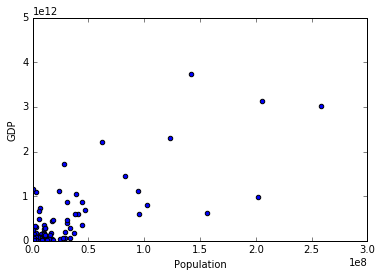

In [66]:
plt.scatter(X['Population'],Y)
plt.ylim(-1000,10000000000000*.5)
plt.xlim(-1000,600000000*.5)
plt.xlabel('Population')
plt.ylabel('GDP')
plt.show()

From the above graph, we see that there isn't a strong correlation between population and GDP. One distinction that we do see is in order for most countries to have a GDP greater than a trillion, they need to have a population greater than 150 million.

# Visualization of landlocked status and GDP

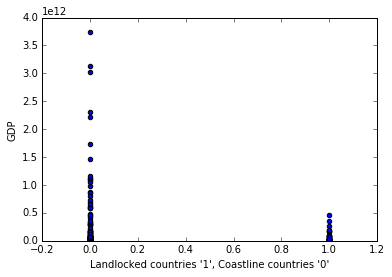

In [63]:
plt.scatter(X['Land Locked'],Y)
plt.ylim(-1000,10000000000000*.4)
# plt.xlim(-1000,600000000)
plt.xlabel("Landlocked countries '1', Coastline countries '0'")
plt.ylabel('GDP')
# red_patch = mpatches.Patch(color='blue', label='0-14 years')
#plt.legend(handles=[red_patch])

plt.show()

From this graph we see that there are poorer countries with coastline, but it appears there is a limit to GDP at around $900,000 for landlocked countries.

# Visulization of literacy rate and GDP

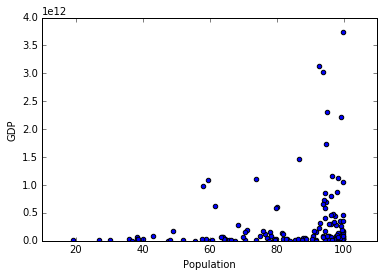

In [64]:
plt.scatter(X['Literacy Rate'],Y)
plt.ylim(-1000,10000000000000*.4)
#plt.xlim(-1000,600000000)
plt.xlabel('Population')
plt.ylabel('GDP')
plt.show()

We used a linear regression for this varible, but an exponential regression may of been better for this function. In general there appears to be a positive correlation between literacy rate and GDP since countries with low literacy rates have very low GDP's even though many countries with higher literacy rates still have lower GDPs.